In [439]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder , StandardScaler
from sklearn.metrics import accuracy_score , classification_report, confusion_matrix
import stat
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.formula.api import ols
import plotly.express as px
import joblib

In [352]:
df = pd.read_csv('/content/heart_disease_dataset.csv')
df.head()

,Age,Gender,Cholesterol,Blood Pressure,Heart Rate,Smoking,Alcohol Intake,Exercise Hours,Family History,Diabetes,Obesity,Stress Level,Blood Sugar,Exercise Induced Angina,Chest Pain Type,Heart Disease
0,75,Female,228,119,66,Current,Heavy,1,No,No,Yes,8,119,Yes,Atypical Angina,1
1,48,Male,204,165,62,Current,NaN,5,No,No,No,9,70,Yes,Typical Angina,0
2,53,Male,234,91,67,Never,Heavy,3,Yes,No,Yes,5,196,Yes,Atypical Angina,1
3,69,Female,192,90,72,Current,NaN,4,No,Yes,No,7,107,Yes,Non-anginal Pain,0
4,62,Female,172,163,93,Never,NaN,6,No,Yes,No,2,183,Yes,Asymptomatic,0


In [353]:
df.shape

(1000, 16)

In [354]:
#univariate statistics
def univariate_stats(df):
    df_output = pd.DataFrame(columns=['Count', 'Missing', 'Unique', 'Dtype', 'Numeric', 'Mode', 'Mean', 'Min', '25%', 'Median',
                                     '75%', 'Max', 'Std', 'Skew', 'Kurt'])
    for col in df:
        count = df[col].count()
        missing = df[col].isnull().sum()
        unique = df[col].nunique()
        dtype = df[col].dtype
        mode = df[col].mode().values[0]
        if pd.api.types.is_numeric_dtype(df[col]):
            mean = df[col].mean()
            min = df[col].min()
            quantile25 = df[col].quantile(0.25)
            median = df[col].median()
            quartile75 = df[col].quantile(0.75)
            max_val = df[col].max()
            std = df[col].std()
            skew = df[col].skew()
            kurt = df[col].kurt()
            df_output.loc[col] = [count, missing, unique, dtype,pd.api.types.is_numeric_dtype(df[col]),mode,
                                  mean, min,quantile25, median, quartile75,max_val,std,skew,kurt]
        else:
            df_output.loc[col] = [count, missing, unique, dtype,pd.api.types.is_numeric_dtype(df[col]),mode,
                                  '-','-','-','-','-','-','-','-','-']
    return df_output.sort_values(by = ['Numeric', 'Skew', 'Unique'], ascending=False)

univariate_stats(df)

,Count,Missing,Unique,Dtype,Numeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
Heart Disease,1000,0,2,int64,True,0,0.392,0,0.0,0.0,1.0,1,0.488441,0.44311,-1.807272
Heart Rate,1000,0,40,int64,True,69,79.204,60,70.0,79.0,89.0,99,11.486092,0.077652,-1.15639
Cholesterol,1000,0,200,int64,True,328,249.939,150,200.0,248.0,299.0,349,57.914673,0.010662,-1.206144
Blood Sugar,1000,0,130,int64,True,135,134.941,70,104.0,135.0,167.0,199,36.699624,0.007381,-1.164871
Exercise Hours,1000,0,10,int64,True,9,4.529,0,2.0,4.5,7.0,9,2.934241,0.004642,-1.245403
Age,1000,0,55,int64,True,37,52.293,25,39.0,52.0,66.0,79,15.727126,-0.028257,-1.16041
Blood Pressure,1000,0,90,int64,True,139,135.281,90,112.75,136.0,159.0,179,26.3883,-0.040332,-1.216661
Stress Level,1000,0,10,int64,True,6,5.646,1,3.0,6.0,8.0,10,2.831024,-0.040693,-1.2047
Chest Pain Type,1000,0,4,object,False,Non-anginal Pain,-,-,-,-,-,-,-,-,-
Smoking,1000,0,3,object,False,Never,-,-,-,-,-,-,-,-,-


In [355]:
def clean_column_names(df):
    new_cols =  []
    for column in df:
        proper_cols = column.title()
        proper_cols_hyphen = proper_cols.replace(' ','_')
        clean_cols = proper_cols_hyphen.replace('-','_')
        new_cols.append(clean_cols)
    df.columns = new_cols
    return df
df = clean_column_names(df)

In [356]:
missing_value = df.isnull().sum()

In [357]:
missing_value_perc = missing_value/df.shape[0]*100
missing_value_perc


,0
Age,0.0
Gender,0.0
Cholesterol,0.0
Blood_Pressure,0.0
Heart_Rate,0.0
Smoking,0.0
Alcohol_Intake,34.0
Exercise_Hours,0.0
Family_History,0.0
Diabetes,0.0


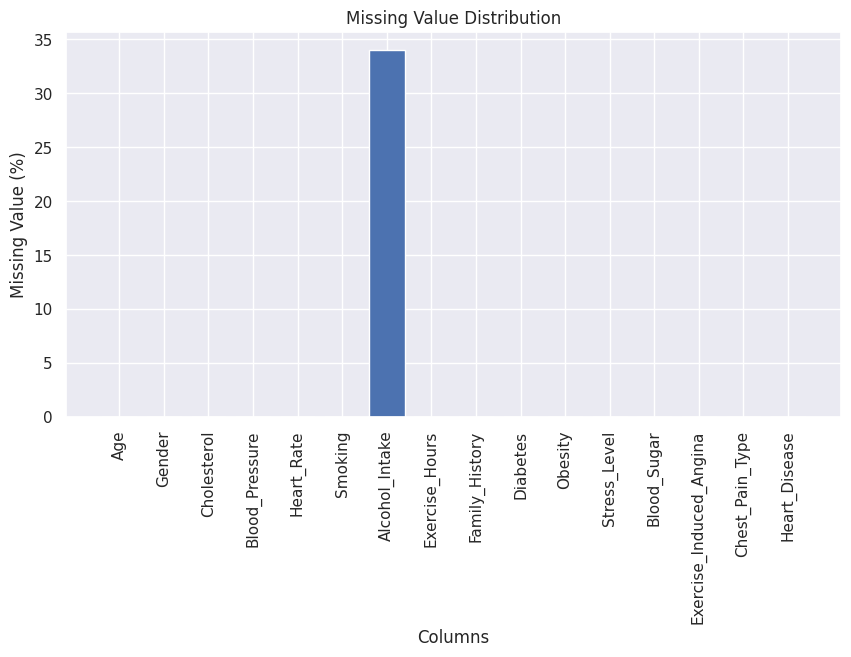

In [358]:
plt.figure(figsize = (10,5))
plt.bar(missing_value_perc.index, missing_value_perc.values)
plt.xlabel('Columns')
plt.ylabel('Missing Value (%)')
plt.xticks(rotation=90)
plt.title('Missing Value Distribution')
plt.show()

In [359]:
df.fillna(value='None', inplace=True) # As the actual value is none but it is consider as NAN so replace it with none
df['Alcohol_Intake'].value_counts()


,count
Alcohol_Intake,
Heavy,346
None,340
Moderate,314


In [360]:
def anova(df, feature, label):
    groups = df[feature].unique()
    df_grouped = df.groupby(feature)
    grouped_labels = []
    for group in groups:
        g_list = df_grouped.get_group(group)
        grouped_labels.append(g_list[label])
    return stats.f_oneway(*grouped_labels)

In [361]:
def heteroscedasticity(df, feature, label):
    formula = f"{label}~{feature}"
    model = ols(formula=formula, data=df).fit()

    output_df = pd.DataFrame(columns=['LM stats', 'LM p', 'F stat', 'F stat p'])
    try:
        white_test = het_white(model.resid, model.model.exog)
        output_df.loc['White'] = white_test
    except:
        print("Unable to run White test of heteroscedasticity")
    breuschpagan_test = het_breuschpagan(model.resid, model.model.exog)
    output_df.loc['Br-pa'] = breuschpagan_test
    return output_df.round(3)


def scatter(feature,label):
    m, b, r, p, err = stats.linregress(feature, label)

    textstr = 'y = ' + str(round(m,2)) + 'x + ' +  str(round(b,2)) + ' \n'
    textstr += 'r2 = ' + str(round(r**2, 2)) + '\n'
    textstr += 'p = ' + str(round(p,2)) + '\n'
    textstr += str(feature.name) + " skew = " + str(round(feature.skew(),2)) + '\n'
    textstr += str(label.name) + " skew = " + str(round(label.skew(),2))+ '\n'
    textstr += str(heteroscedasticity(pd.DataFrame(label).join(pd.DataFrame(feature)), feature.name, label.name))

    sns.set(color_codes = True)
    ax = sns.jointplot(x = feature, y = label, kind = 'reg');
    ax.fig.text(1, 0.114, textstr, fontsize=12, transform= plt.gcf().transFigure)
    plt.show()

In [362]:
def bar_chart(df, feature, label):
    # Prepare data for statistical tests
    groups = df[feature].unique()
    df_grouped = df.groupby(feature)
    grouped_labels = [df_grouped.get_group(group)[label].values for group in groups]

    one_way = stats.f_oneway(*grouped_labels)

    # T-tests
    ttests = []
    for i, group1 in enumerate(groups):
        for group2 in groups[i+1:]:
            g1 = df[df[feature] == group1][label]
            g2 = df[df[feature] == group2][label]

            if len(g1) < 2 or len(g2) < 2:
                print(f"'{group1}' n = {len(g1)} '{group2}' n = {len(g2)}; no T-test performed")
            else:
                t, p = stats.ttest_ind(g1, g2)
                ttests.append([group1, group2, t, p])

    # Bonferroni correction
    if len(ttests) > 0:
        threshold = 0.05 / len(ttests)
    else:
        threshold = 0.05

    # Prepare text for statistical results
    textstr = 'ANOVA\n'
    textstr += f'F: {one_way.statistic:.4f}\n'
    textstr += f'P: {one_way.pvalue:.4f}\n'
    textstr += 'Sig. Comparisons (Bonferroni)\n'

    for group1, group2, t, p in ttests:
        if p <= threshold:
            textstr += f'{group1}-{group2}: t={t:.4f}, p={p:.4f}\n'

    ax = sns.barplot(x = df[feature], y = df[label])
    ax.text(1, 0.1, textstr, fontsize=12, transform=plt.gcf().transFigure)
    plt.xticks(rotation=90)
    plt.show()

In [363]:
#BiVariate: Numeric to Numeric: COrelation
#BiVariate: Numeric to Categorical: one-way ANOVA (3+ groups) or t-test (2 groups)
#BiVariate: Categorical to Categorical: Chi-square
def bivariate_stats(df, label):
    output_df = pd.DataFrame(columns=['Stat', '+/-', 'Effect size', 'p-value'])
    for col in df:
        if not col == label:
            if df[col].isnull().sum() == 0 :
                if pd.api.types.is_numeric_dtype(df[col]):
                    r, p = stats.pearsonr(df[label] , df[col])
                    output_df.loc[col] = ['r', np.sign(r), abs(round(r,3)), round(p,6)]
                    scatter(df[col], df[label])
                else:
                    F, p = anova(df[[col, label]], col, label)
                    output_df.loc[col] = ['F', '', round(F,3), round(p,6)]
                    bar_chart(df, col, label)
            else:
                output_df.loc[col] = [np.nan, np.nan, np.nan, 'nulls']
    return output_df.sort_values(by=[ 'Stat', 'Effect size'], ascending=False)

**1. ANOVA (Analysis of Variance)**

F-statistic: Higher values indicate that group means are different relative to the variation within groups.

p-value: If the p-value < 0.05, it suggests that the differences between the group means are statistically significant.

**2. Breusch-Pagan Test (for heteroscedasticity):**

If the p-value is less than 0.05, heteroscedasticity is present (the error variance is not constant).

**3. White Test (for heteroscedasticity and model misspecification)**

Similar to the Breusch-Pagan test, if the p-value is less than 0.05, it indicates heteroscedasticity and also potential misspecification of the model.

**4. Pearson Correlation**

r: A value close to 1 or -1 indicates a strong linear relationship, while a value close to 0 indicates little to no linear relationship.

p-value: A p-value < 0.05 indicates that the correlation is statistically significant.

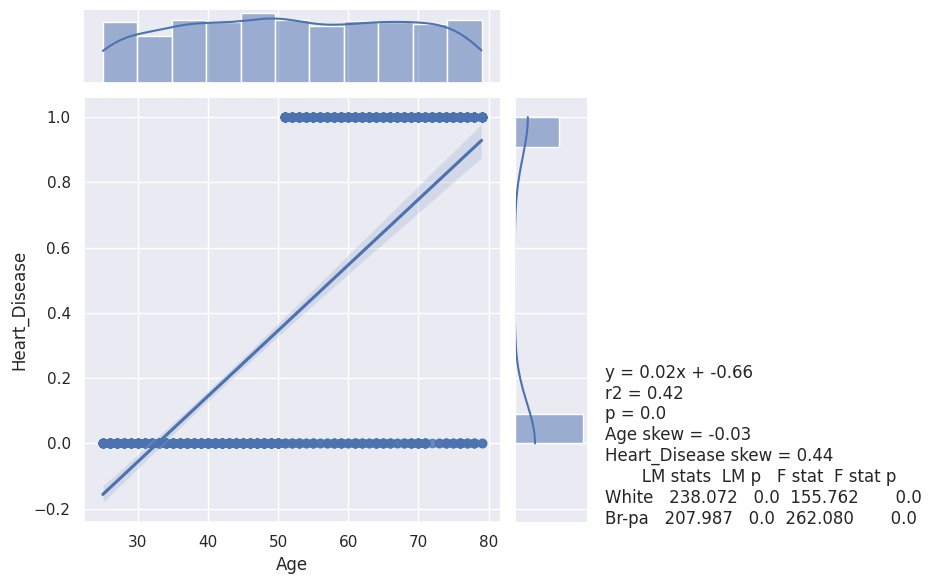

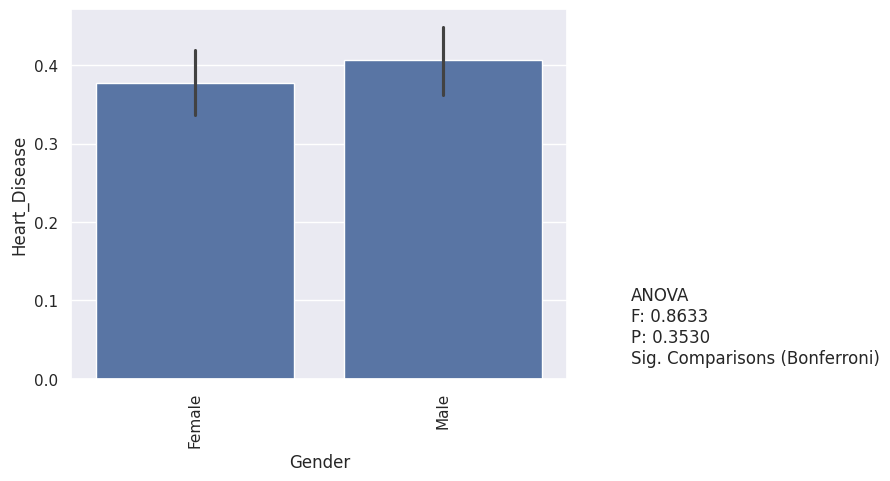

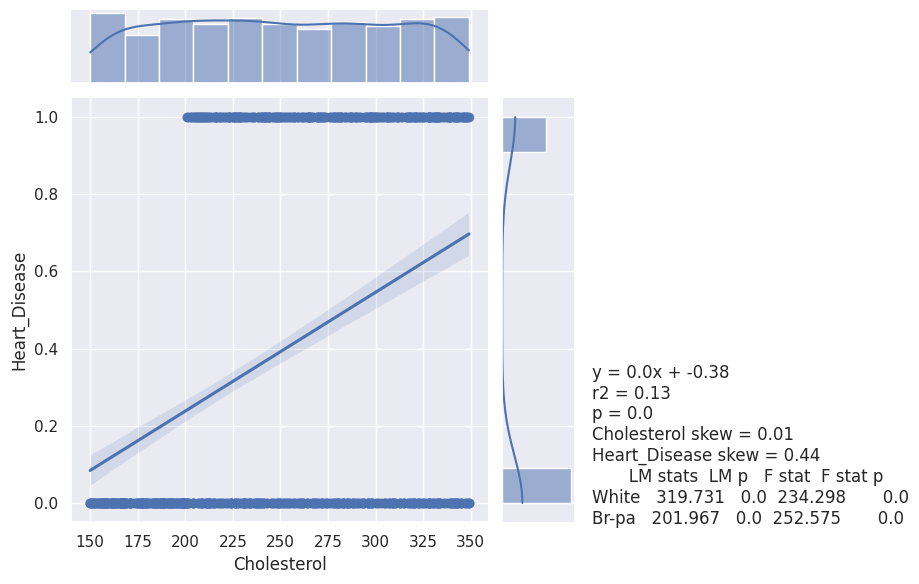

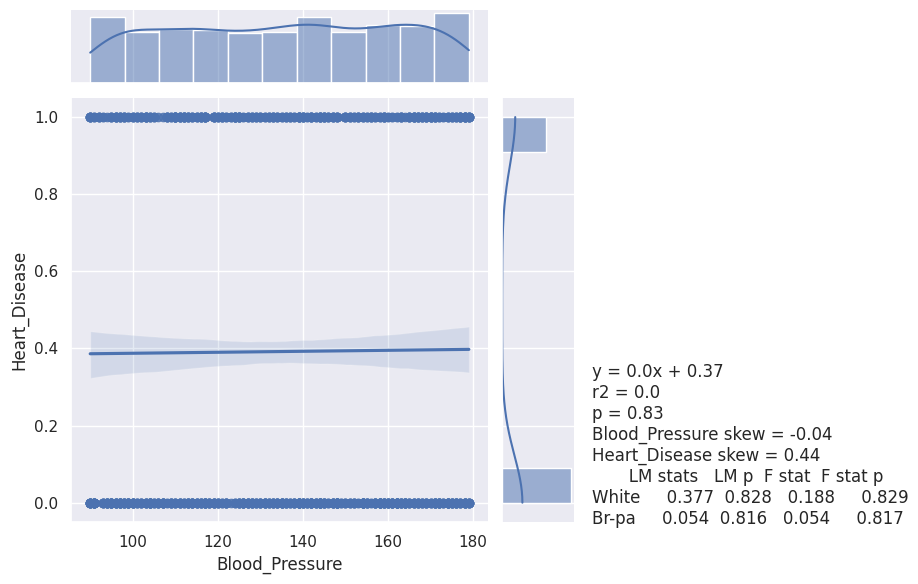

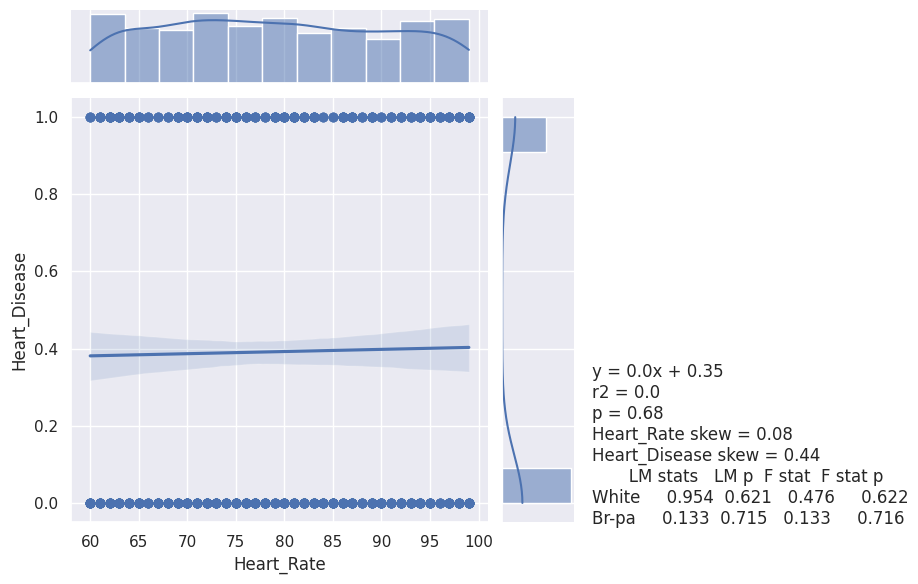

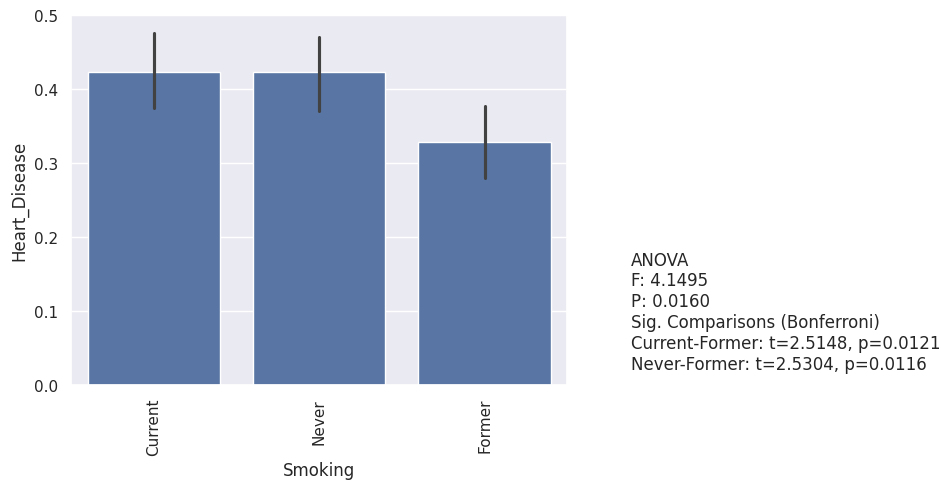

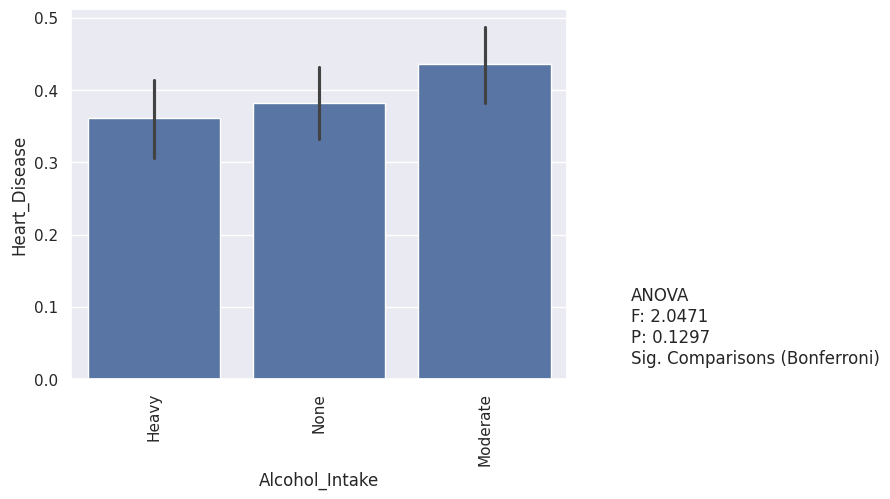

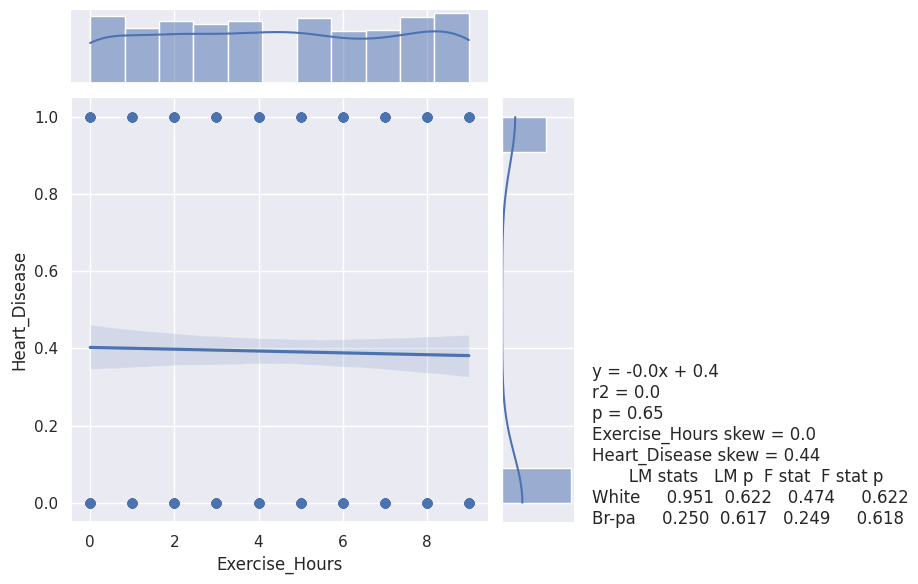

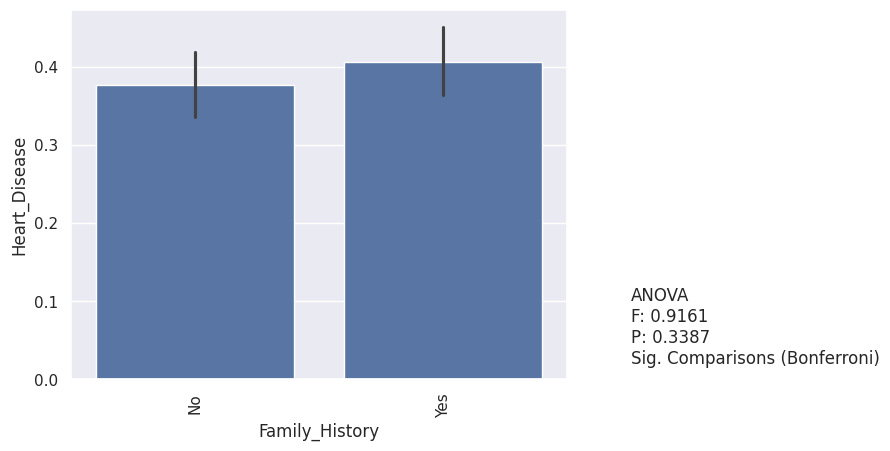

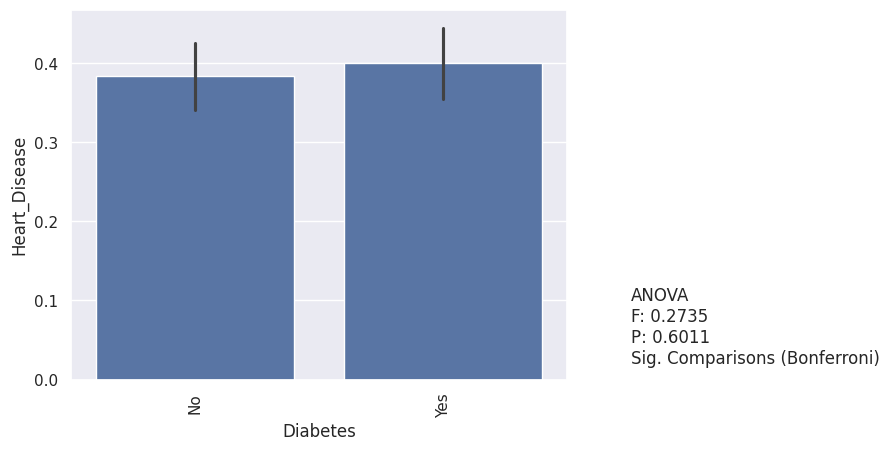

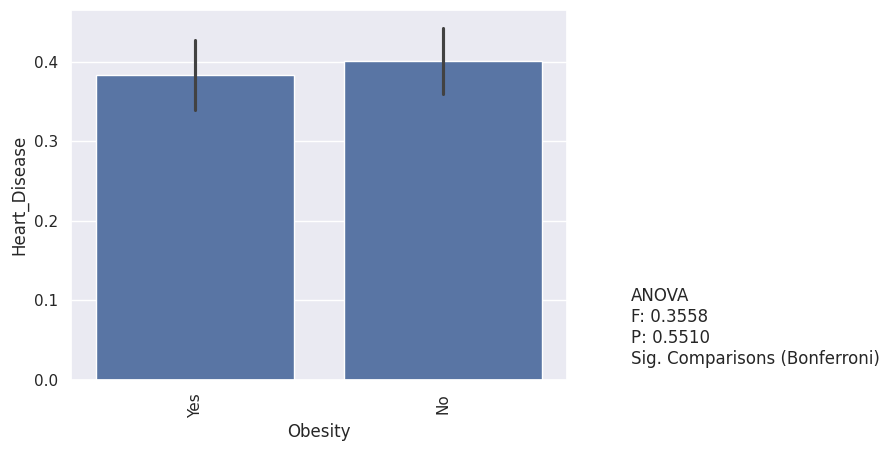

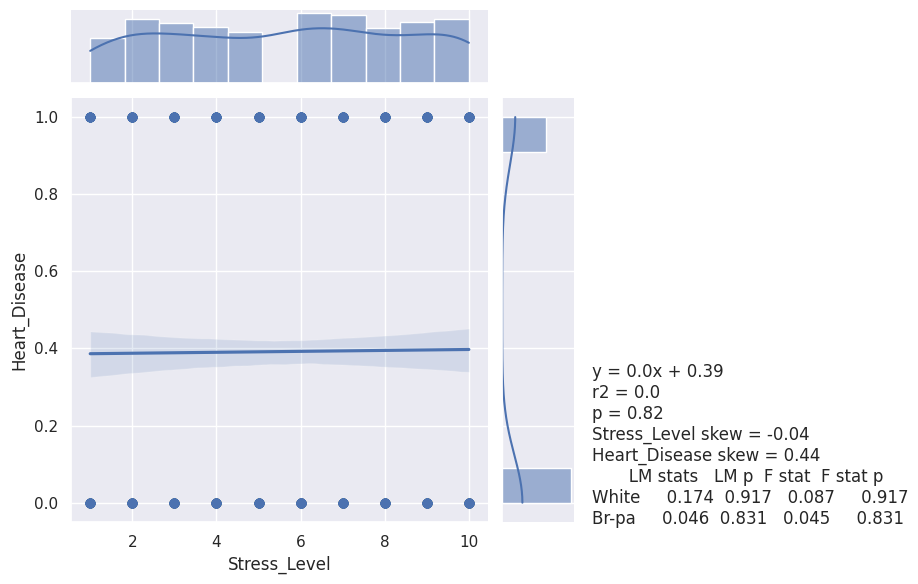

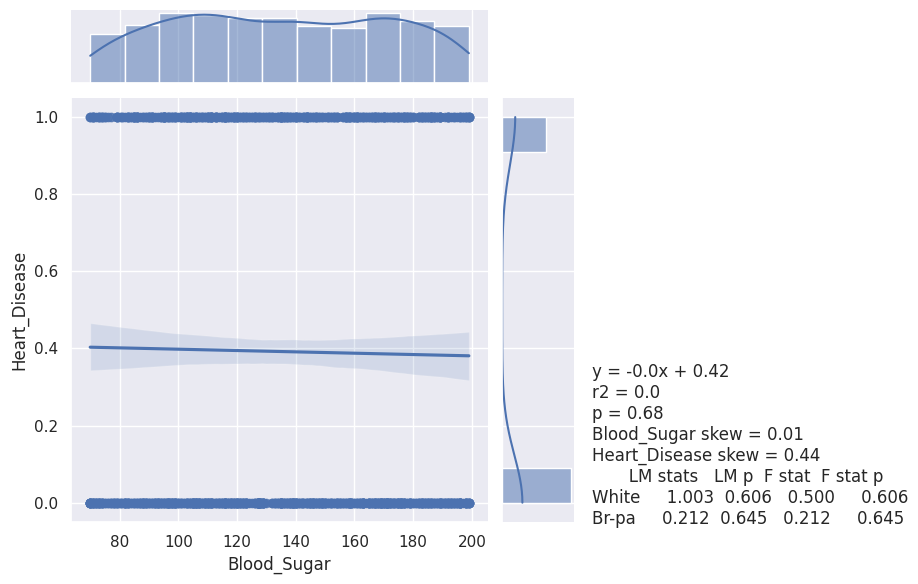

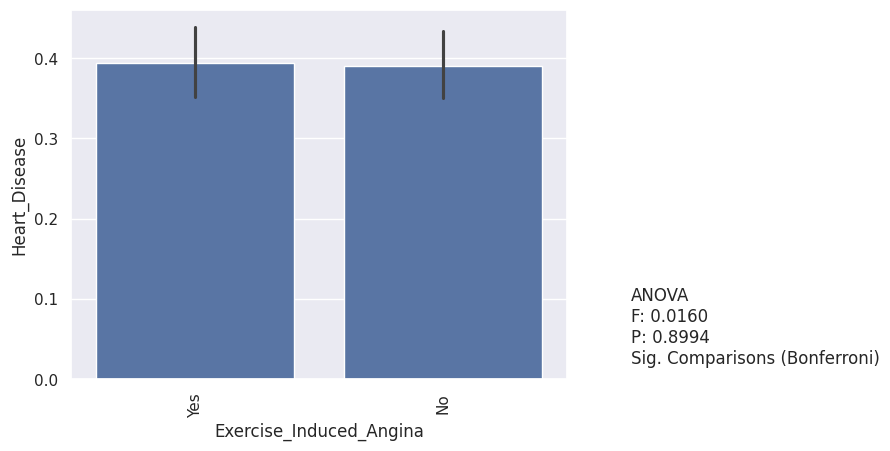

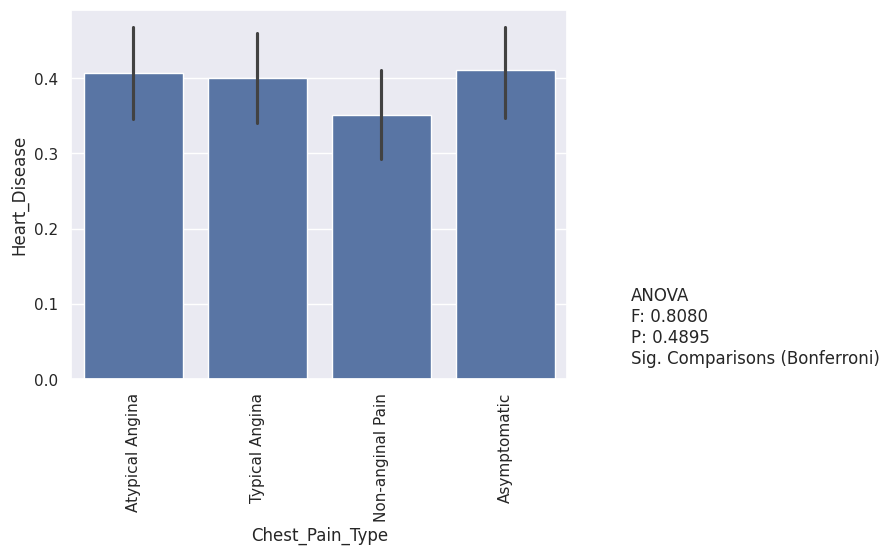

,Stat,+/-,Effect size,p-value
Age,r,1.0,0.647,0.000000
Cholesterol,r,1.0,0.365,0.000000
Exercise_Hours,r,-1.0,0.014,0.653202
Heart_Rate,r,1.0,0.013,0.676532
Blood_Sugar,r,-1.0,0.013,0.681273
Blood_Pressure,r,1.0,0.007,0.827482
Stress_Level,r,1.0,0.007,0.823279
Smoking,F,,4.150,0.016045
Alcohol_Intake,F,,2.047,0.129652
Family_History,F,,0.916,0.338743


In [364]:
bivariate_stats(df, 'Heart_Disease')

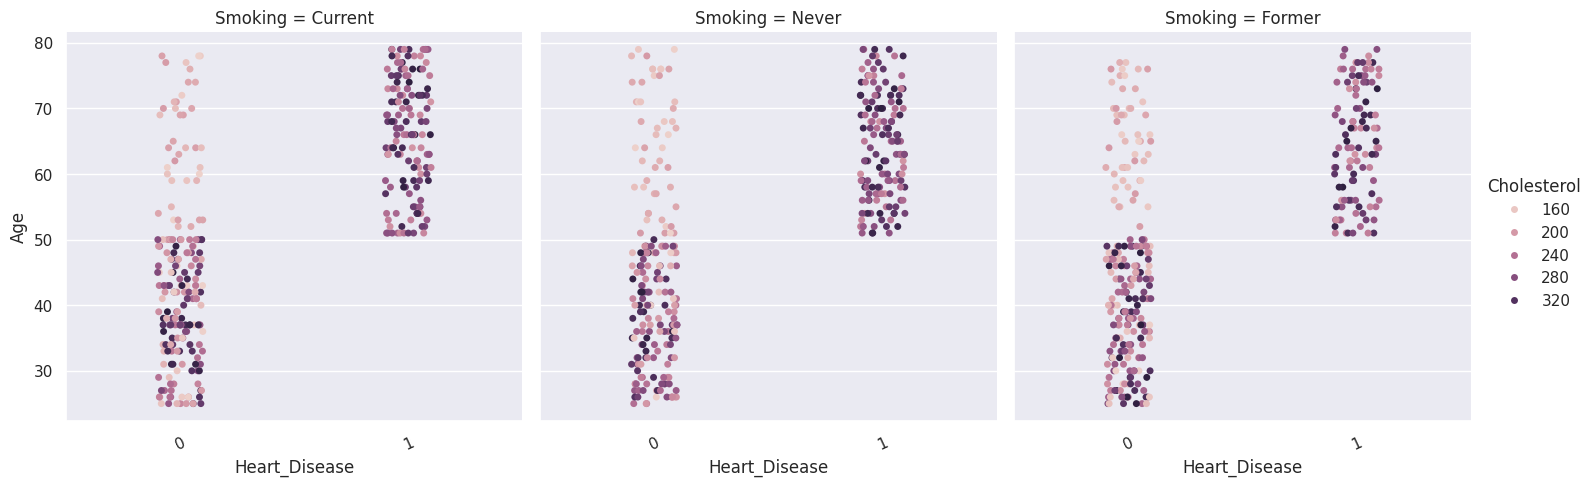

In [365]:
vlz = sns.catplot(data =df,  x='Heart_Disease', y='Age', hue='Cholesterol', col="Smoking");
vlz.set_xticklabels(rotation = 25);

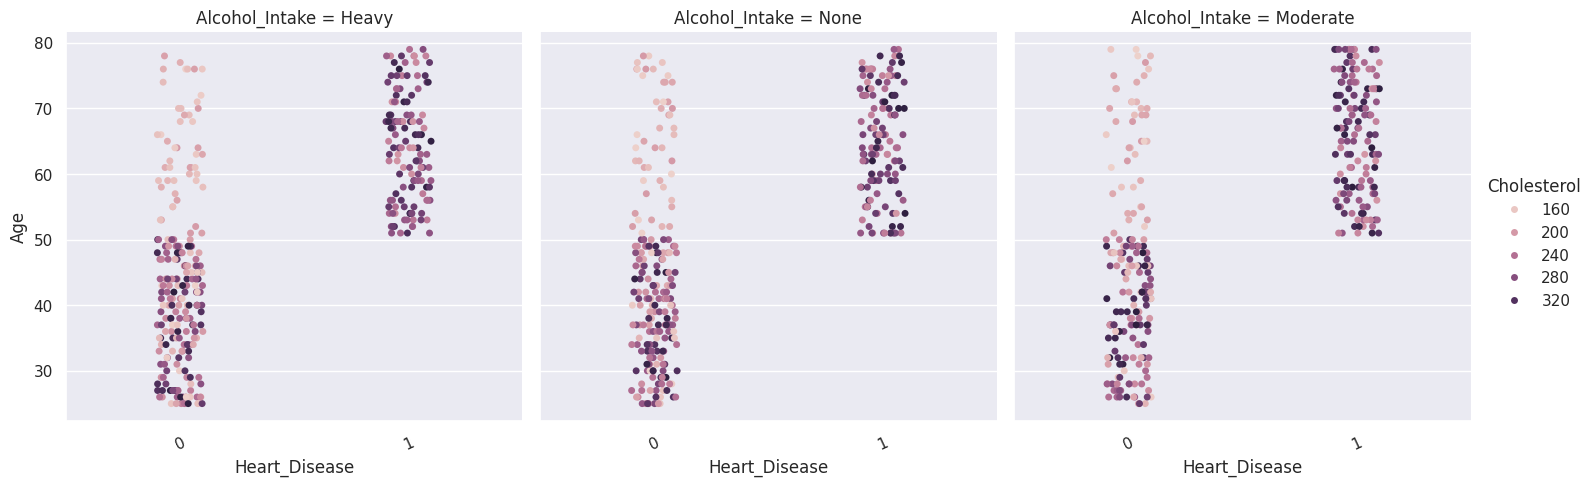

In [366]:
vlz = sns.catplot(data =df,  x='Heart_Disease', y='Age', hue='Cholesterol', col="Alcohol_Intake");
vlz.set_xticklabels(rotation = 25);

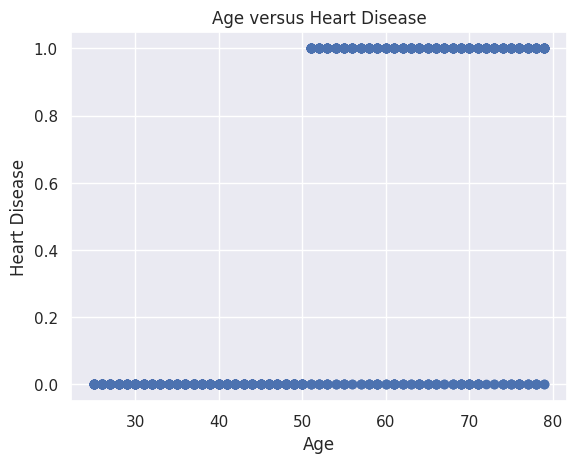

In [367]:
plt.scatter(df['Age'],df['Heart_Disease'])
plt.title("Age versus Heart Disease")
plt.xlabel('Age')
plt.ylabel('Heart Disease')
plt.show()

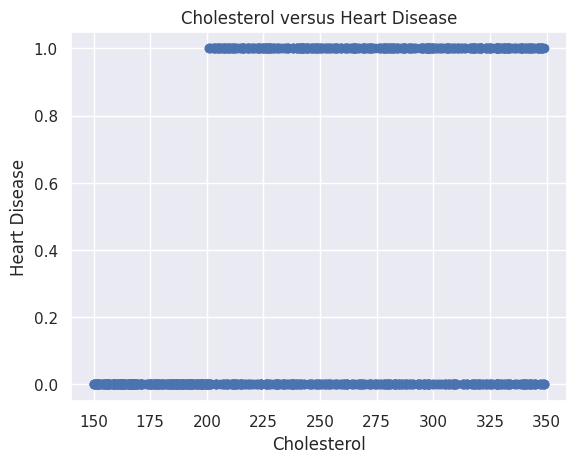

In [368]:
plt.scatter(df['Cholesterol'],df['Heart_Disease'])
plt.title("Cholesterol versus Heart Disease")
plt.xlabel('Cholesterol')
plt.ylabel('Heart Disease')
plt.show()

In [369]:
df['Smoking'].value_counts()

,count
Smoking,
Never,338
Current,336
Former,326


In [370]:
Smoking_Never = df[df['Smoking'] == 'Never']
Smoking_Current = df[df['Smoking'] == 'Current' ]
Smoking_Former = df[df['Smoking'] == 'Former' ]

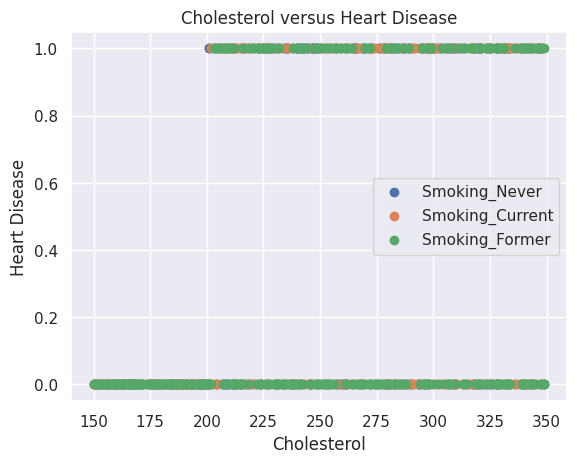

In [371]:
plt.scatter(Smoking_Never.Cholesterol , Smoking_Never.Heart_Disease, label = 'Smoking_Never')
plt.scatter(Smoking_Current.Cholesterol , Smoking_Current.Heart_Disease, label = 'Smoking_Current')
plt.scatter(Smoking_Former.Cholesterol , Smoking_Former.Heart_Disease, label = 'Smoking_Former')
plt.title("Cholesterol versus Heart Disease")
plt.xlabel('Cholesterol')
plt.ylabel('Heart Disease')
plt.legend()
plt.show()

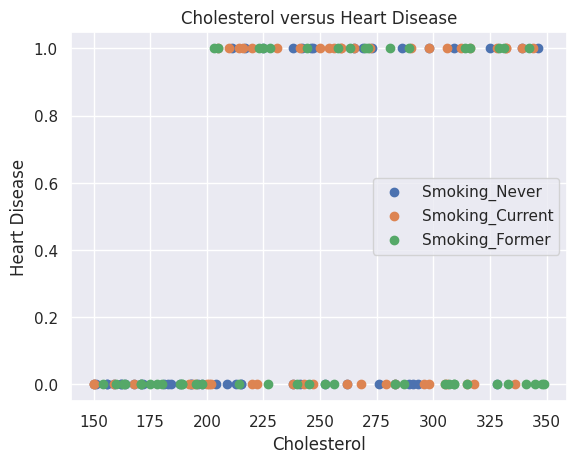

In [372]:
Smoking_Never_red = Smoking_Never.sample(50)
Smoking_Current_red = Smoking_Current.sample(50)
Smoking_Former_red = Smoking_Former.sample(50)
plt.scatter(Smoking_Never_red.Cholesterol , Smoking_Never_red.Heart_Disease, label = 'Smoking_Never')
plt.scatter(Smoking_Current_red.Cholesterol , Smoking_Current_red.Heart_Disease, label = 'Smoking_Current')
plt.scatter(Smoking_Former_red.Cholesterol , Smoking_Former_red.Heart_Disease, label = 'Smoking_Former')
plt.title("Cholesterol versus Heart Disease")
plt.xlabel('Cholesterol')
plt.ylabel('Heart Disease')
plt.legend()
plt.show()

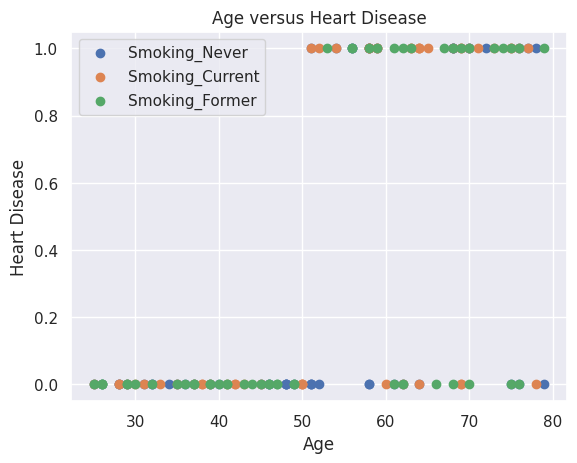

In [373]:
plt.scatter(Smoking_Never_red.Age , Smoking_Never_red.Heart_Disease, label = 'Smoking_Never')
plt.scatter(Smoking_Current_red.Age , Smoking_Current_red.Heart_Disease, label = 'Smoking_Current')
plt.scatter(Smoking_Former_red.Age , Smoking_Former_red.Heart_Disease, label = 'Smoking_Former')
plt.title("Age versus Heart Disease")
plt.xlabel('Age')
plt.ylabel('Heart Disease')
plt.legend()
plt.show()

In [374]:
fig = px.scatter_3d(df.sample(100), x='Age', y='Heart_Disease', z='Cholesterol', color='Alcohol_Intake')
fig.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



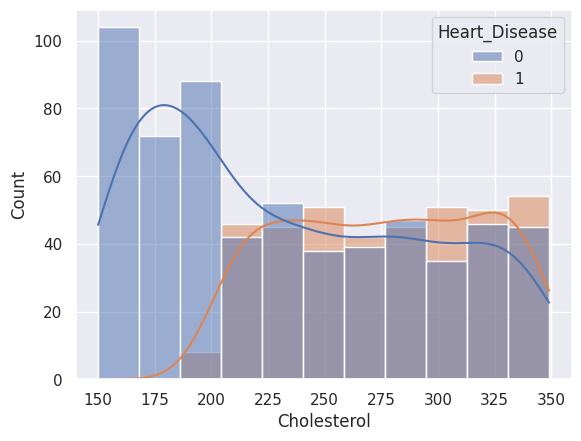

In [375]:
sns.histplot(data=df, x = 'Cholesterol', hue = 'Heart_Disease', kde = True);

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



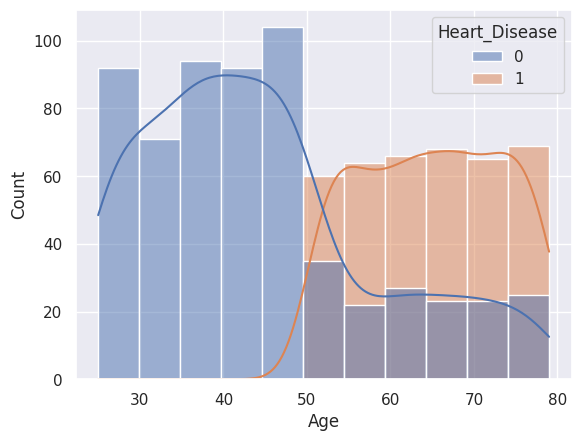

In [376]:
sns.histplot(data=df, x = 'Age', hue = 'Heart_Disease', kde = True);

In [377]:
cat_col = [col for col in df.columns if df[col].dtype == 'object']
encoder = OneHotEncoder(sparse_output = False, drop = 'first')
encoded_data = encoder.fit_transform(df[cat_col])

In [378]:
numeric_features = [col for col in df.columns if df[col].dtype != 'object' and col != 'Heart_Disease']
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df[numeric_features]), columns= numeric_features)
df_encoded = pd.concat([pd.DataFrame(encoded_data, columns = encoder.get_feature_names_out()), scaled_df, df['Heart_Disease'].reset_index(drop=True)], axis = 1)
df_encoded.head()

,Gender_Male,Smoking_Former,Smoking_Never,Alcohol_Intake_Moderate,Alcohol_Intake_None,Family_History_Yes,Diabetes_Yes,Obesity_Yes,Exercise_Induced_Angina_Yes,Chest_Pain_Type_Atypical Angina,Chest_Pain_Type_Non-anginal Pain,Chest_Pain_Type_Typical Angina,Age,Cholesterol,Blood_Pressure,Heart_Rate,Exercise_Hours,Stress_Level,Blood_Sugar,Heart_Disease
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.444534,-0.379005,-0.617287,-1.150139,-1.203298,0.831917,-0.434581,1
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.273104,-0.793616,1.126782,-1.498561,0.160599,1.185323,-1.770413,0
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.044977,-0.275353,-1.678894,-1.063034,-0.521350,-0.228300,1.664583,1
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.062836,-1.000921,-1.716808,-0.627507,-0.180375,0.478511,-0.761724,0
4,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.617523,-1.346429,1.050953,1.201706,0.501573,-1.288517,1.310178,0


In [379]:
#Mutual Information for Binary Classification:

from sklearn.feature_selection import mutual_info_classif

X = df_encoded.drop('Heart_Disease', axis=1)
y = df_encoded['Heart_Disease']

mi_scores = mutual_info_classif(X, y)

mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_scores})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

print(mi_df)

                             Feature  Mutual Information
12                               Age            0.369944
13                       Cholesterol            0.152464
15                        Heart_Rate            0.021879
3            Alcohol_Intake_Moderate            0.019191
17                      Stress_Level            0.017347
11    Chest_Pain_Type_Typical Angina            0.010201
5                 Family_History_Yes            0.008463
14                    Blood_Pressure            0.007881
1                     Smoking_Former            0.007719
8        Exercise_Induced_Angina_Yes            0.003002
0                        Gender_Male            0.000000
16                    Exercise_Hours            0.000000
9    Chest_Pain_Type_Atypical Angina            0.000000
10  Chest_Pain_Type_Non-anginal Pain            0.000000
7                        Obesity_Yes            0.000000
6                       Diabetes_Yes            0.000000
4                Alcohol_Intake

In [426]:
clf = RandomForestClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)
decision_tree = DecisionTreeClassifier(max_depth=3, random_state = 42)
log_reg_classifier = LogisticRegression(max_iter=1000, random_state=42)
#Threshold for feature selection
threshold = 0.01
selected_features = mi_df[mi_df['Mutual Information'] > threshold]['Feature']
x_selected = X[selected_features]

In [428]:
X_train, X_test, y_train, y_test = train_test_split(x_selected, y, test_size=0.2, random_state=42)

In [403]:
# Decision Tree Classifier
decision_tree.fit(X_train, y_train)
y_pred_dt = decision_tree.predict(X_test)
print("Decision Tree Classifier Results:")
print(classification_report(y_test, y_pred_dt))
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Decision Tree Classifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       1.00      1.00      1.00        82

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Accuracy: 1.0
Confusion Matrix:
 [[118   0]
 [  0  82]]


In [429]:
# Random Forest Classifier
clf.fit(X_train, y_train)
y_pred_clf = clf.predict(X_test)
print("Random Forest Classifier Results:")
print(classification_report(y_test, y_pred_clf))
print("Accuracy:", accuracy_score(y_test, y_pred_clf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_clf))

Random Forest Classifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       1.00      1.00      1.00        82

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Accuracy: 1.0
Confusion Matrix:
 [[118   0]
 [  0  82]]


In [430]:
#Cross Validation using StratidiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(clf, x_selected, y, cv=skf)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())


Cross-Validation Scores: [1.    1.    1.    0.995 1.   ]
Mean CV Score: 0.999


[0 1 2 4 3 5]
[0.63991679 0.32577741 0.01782075 0.00291568 0.01146457 0.00210481]


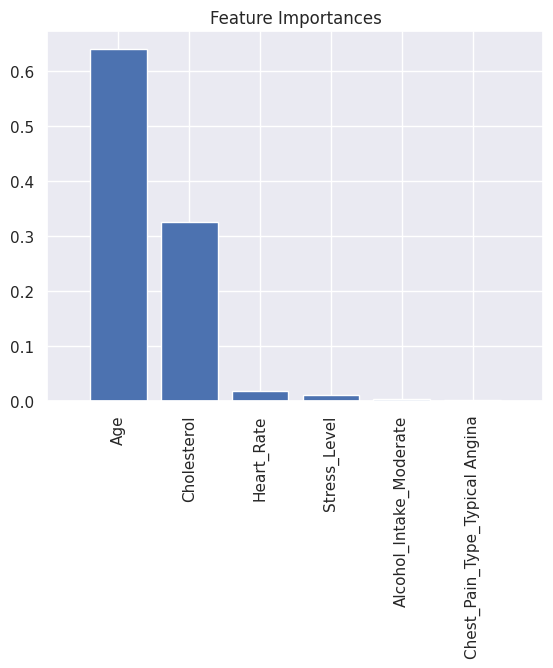

In [434]:

feature_importances = clf.feature_importances_
indices = np.argsort(feature_importances)[::-1]
plt.figure()
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


In [384]:
# Logistic Regression
log_reg_classifier.fit(X_train, y_train)
y_pred_lr = log_reg_classifier.predict(X_test)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       118
           1       0.85      0.84      0.85        82

    accuracy                           0.88       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.87      0.88      0.87       200

Accuracy: 0.875
Confusion Matrix:
 [[106  12]
 [ 13  69]]


In [413]:
from sklearn.model_selection import GridSearchCV

# parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs', 'newton-cholesky']
}

grid_search = GridSearchCV(estimator=log_reg_classifier, param_grid=param_grid,
                           scoring='accuracy', cv=10, verbose=1)

grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Score: 0.8637500000000001


In [414]:
best_log_reg = grid_search.best_estimator_

y_pred_best_lr = best_log_reg.predict(X_test)

print("Tuned Logistic Regression Results:")
print(classification_report(y_test, y_pred_best_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_best_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_lr))

Tuned Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       118
           1       0.84      0.85      0.85        82

    accuracy                           0.88       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.88      0.88      0.88       200

Accuracy: 0.875
Confusion Matrix:
 [[105  13]
 [ 12  70]]


In [438]:
#Final Model
clf.fit(x_selected, y)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

In [440]:
joblib.dump(clf, 'random_forest_model.pkl')

['random_forest_model.pkl']